### Predict if a NYS Worker's Compensation claim will close as one of 4 Final Settlement types:

* Section 32
* PPD Scheduled Loss 
* PPD Non-Scheduled Loss 
* PTD

- [Link to WC Dataset](https://data.ny.gov/Government-Finance/Assembled-Workers-Compensation-Claims-Beginning-20/jshw-gkgu) Assembled Workers' Compensation Claims: Beginning 2000
- [Link to WC Dataset Dictionary](https://data.ny.gov/api/views/6r4d-hp7p/files/15iRqbPHklkRLpJelhaiI96RUWN0flYW5WbADuGuVII?download=true&filename=NYSWCB_ClaimsAssembled_Data_Dictionary.pdf)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import feather
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# only read in first 100000 rows == 2% of total dataset rows from WC Dataset
df=pd.read_feather('df_partwc.ftr') 
df.shape

(100000, 52)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 52 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Unnamed: 0                          100000 non-null  int64  
 1   Claim Identifier                    100000 non-null  int64  
 2   Claim Type                          100000 non-null  object 
 3   District Name                       100000 non-null  object 
 4   Average Weekly Wage                 100000 non-null  object 
 5   Current Claim Status                100000 non-null  object 
 6   Claim Injury Type                   100000 non-null  object 
 7   Age at Injury                       100000 non-null  int64  
 8   Assembly Date                       100000 non-null  object 
 9   Accident Date                       98848 non-null   object 
 10  ANCR Date                           43025 non-null   object 
 11  Controverted Date          

In [ ]:
df.shape
# (100000, 52)

(100000, 52)

In [37]:
#show the # of each type of settlement in dataset/ % of claims in sample dataset settled under each type
disp_cols=['Section 32 Date','PPD Scheduled Loss Date','PPD Non-Scheduled Loss Date','PTD Date']

(df[disp_cols].notnull().sum()/100000)*100
# Section 32 Date                4892
# PPD Scheduled Loss Date        9183
# PPD Non-Scheduled Loss Date    2225
# PTD Date                        214
# dtype: int64
# Total:                        16514

# Section 32 Date                4.892
# PPD Scheduled Loss Date        9.183
# PPD Non-Scheduled Loss Date    2.225
# PTD Date                       0.214
# dtype: float64

Section 32 Date                4.892
PPD Scheduled Loss Date        9.183
PPD Non-Scheduled Loss Date    2.225
PTD Date                       0.214
dtype: float64

### Create target by combining the 4 types of final WC claim dispositions into one column

In [5]:
# Create a Final disposition column to use as target- combines all final disposition classes into one column
# Create a Final disposition date column - combines all final disposition dates into one column
# Create a Days_Accid_Final column = days claim opened from date of accident to final disposition date
# Create a Days_Assemb_Final column = days claim opened from date of assembly to final disposition date
from create_cols import add_cols_df, combine_disposition_cols

# created new dataframe with 4 new columns
new_cols=['Final_disposition', 'Final_disposition_Date', 'Days_Accid_Final', 'Days_Assemb_Final']

disp_df = add_cols_df(df, new_cols)

# disp_df.shape
# (99975, 56)

In [6]:
# gets all rows with a certain type of final disposition that is not null and adds the disposition date to new col and type of disposition 
# string to Final Disposition
ppd_df = combine_disposition_cols(disp_df, 'PPD Non-Scheduled Loss Date', 'Final_disposition_Date', 'Final_disposition','PPD')
slu_df = combine_disposition_cols(disp_df, 'PPD Scheduled Loss Date', 'Final_disposition_Date', 'Final_disposition','SLU')
s32_df = combine_disposition_cols(disp_df, 'Section 32 Date', 'Final_disposition_Date', 'Final_disposition','S32')
ptd_df = combine_disposition_cols(disp_df, 'PTD Date', 'Final_disposition_Date', 'Final_disposition','PTD')

/content/create_cols.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_df[combdate_col]=select_df[date_col]
/content/create_cols.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_df[disp_word_col]=disp_word


In [ ]:
print(ppd_df.shape,slu_df.shape,s32_df.shape,ptd_df.shape)
# (2225, 54) (9183, 54) (4892, 54) (214, 54)

(2225, 56) (9183, 56) (4892, 56) (214, 56)


In [9]:
# combine original df with ppd_df,slu_df,s32_df and ptd_df
comb_disp_df = pd.concat([disp_df,s32_df,slu_df,ppd_df,ptd_df],ignore_index=True,axis=0)

In [8]:
#drop original disposition rows from combined disp df by index
from getidx import get_df_idx
dfs=[s32_df,slu_df,ppd_df,ptd_df]

# get indexes of disp dfs 
idx_droplist= get_df_idx(dfs)
idx_droplist

comb_disp_df.drop(labels=idx_droplist, axis=0, inplace= True)
comb_disp_df.shape
# (100983, 56)

(100983, 56)

### Select only rows with final dispositions

In [10]:
final_df= comb_disp_df[comb_disp_df['Final_disposition'].notnull()]
# final_df.shape
# (16509, 56)

In [ ]:
final_df.Days_Accid_Final.isnull().sum()

16514

In [ ]:
# final_df['Final_disposition'].value_counts()
# SLU    9183
# S32    4887
# PPD    2225
# PTD     214
# Name: Final_disposition, dtype: int64

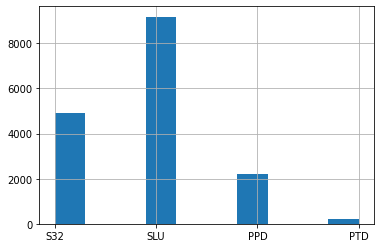

In [11]:
final_df['Final_disposition'].hist();

### Cleaning numeric values

In [ ]:
# remove comma and replace Nan values with zero and cast as new datatype
from clean_num import strip_char
from not_num import not_num_replace
from type_col import type_col

In [ ]:
# Unable to parse string "0148P" at position 3737
# Unable to parse string "05-14" at position 7804

# get index of rows where column value is not a digit and replace with another value
# Change Zip Code and AWW columns to float, strip ',' and replace Nan with 0 ,
int_col= 'Zip Code'

not_num_replace(final_df, int_col, 0)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [ ]:
def type_col(df,col,typecast):
  df[col]=df[col].str.replace(',', '').replace('-','').replace([None],0).astype(typecast)
  return df

In [ ]:
# Remove commas from values and cast as float type

AWW= 'Average Weekly Wage'

type_col(final_df,AWW, float)

# NameError: name 'np' is not defined error when try to call function

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# remove asterisk from oiics code columns, replace Nan with zero, and cast all as type integer
oiics_codes_list= ['OIICS Part Of Body Code','OIICS Nature of Injury Code','OIICS Injury Source Code','OIICS Event Exposure Code',
                   'OIICS Secondary Source Code']
                   
final_df[oiics_codes_list]=final_df[oiics_codes_list].apply(strip_char).replace(np.NaN,0).astype('int')

Coerce dates to datetime

In [ ]:
# find all column names with word Date and Days and coerce to datetime
date='Date'
day='Days'

dates=[name for name in final_df.columns if date in name]
days = [name for name in final_df.columns if day in name]

date_names = dates+days

final_df[date_names]=final_df[date_names].apply(pd.to_datetime,errors='coerce')

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
# find difference in days from two datetime column values

final_df['Days_Accid_Final']=final_df['Final_disposition_Date']-final_df['Accident Date']
final_df['Days_Assemb_Final']=final_df['Final_disposition_Date']-final_df['Assembly Date']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
# Getting the integer portion of the timedelta to get # of days
final_df['Days_Accid_Final']=final_df['Days_Accid_Final'].dt.days
final_df['Days_Assemb_Final']=final_df['Days_Assemb_Final'].dt.days

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
final_df.info()

### Dropping unneeded columns and rows

In [ ]:
# unneeded columns 'Section 32 Date','PPD Scheduled Loss Date','PPD Non-Scheduled Loss Date','PTD Date' as they are now all 
# combined into Final Disposition Date column
unneed_cols= ['Unnamed: 0', 'Claim Identifier', 'Section 32 Date','PPD Scheduled Loss Date','PPD Non-Scheduled Loss Date',
              'PTD Date','Medical Fee Region']

# Get column names with word Description and drop, value captured in the associated code columns
description='Description'
desc_cols = [name for name in final_df.columns if description in name]

drop_cols = unneed_cols + desc_cols

scoped_df= final_df.drop(columns=drop_cols,axis=1)

In [ ]:
final_df.shape,scoped_df.shape
((16514, 56), (16514, 41))

In [ ]:
scoped_df.describe()

,Average Weekly Wage,Age at Injury,WCIO Part Of Body Code,WCIO Nature of Injury Code,WCIO Cause of Injury Code,OIICS Part Of Body Code,OIICS Nature of Injury Code,OIICS Injury Source Code,OIICS Event Exposure Code,OIICS Secondary Source Code,Birth Year,Hearing Count,Closed Count,IME-4 Count,Days_Accid_Final,Days_Assemb_Final
count,16514.000000,16514.000000,8172.000000,7866.000000,7874.000000,16514.000000,16514.000000,16514.000000,16514.000000,16514.000000,16514.000000,16514.000000,16514.000000,13849.000000,16472.000000,16514.000000
mean,1029.560812,41.195713,45.394763,43.395627,52.012827,18.676093,4.664648,42.032639,16.096585,43.573211,1172.823301,4.937205,4.662892,5.162467,1364.951251,1202.401356
std,1279.813668,16.730467,18.955766,20.621546,24.147709,16.681049,13.938508,32.175465,19.623815,35.118114,963.295256,4.614556,3.081233,5.286153,1095.737882,941.602392
min,0.000000,0.000000,10.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,38.000000,4.000000
25%,591.610000,34.000000,35.000000,28.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,680.000000,588.000000
50%,872.370000,44.000000,42.000000,49.000000,56.000000,21.000000,1.000000,56.000000,13.000000,49.000000,1953.000000,4.000000,4.000000,3.000000,1026.000000,918.000000
75%,1346.150000,53.000000,53.000000,52.000000,68.000000,32.000000,2.000000,62.000000,22.000000,74.000000,1966.000000,7.000000,6.000000,7.000000,1648.000000,1483.750000
max,121298.000000,95.000000,99.000000,91.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,1999.000000,50.000000,31.000000,96.000000,12261.000000,7146.000000


In [ ]:
num_df = scoped_df.select_dtypes(include='number')

In [ ]:
obj_df = scoped_df.select_dtypes(exclude='number')

In [ ]:
num_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16514 entries, 100000 to 116513
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Average Weekly Wage          16514 non-null  float64
 1   Age at Injury                16514 non-null  int64  
 2   WCIO Part Of Body Code       8172 non-null   float64
 3   WCIO Nature of Injury Code   7866 non-null   float64
 4   WCIO Cause of Injury Code    7874 non-null   float64
 5   OIICS Part Of Body Code      16514 non-null  int64  
 6   OIICS Nature of Injury Code  16514 non-null  int64  
 7   OIICS Injury Source Code     16514 non-null  int64  
 8   OIICS Event Exposure Code    16514 non-null  int64  
 9   OIICS Secondary Source Code  16514 non-null  int64  
 10  Birth Year                   16514 non-null  int64  
 11  Hearing Count                16514 non-null  int64  
 12  Closed Count                 16514 non-null  int64  
 13  IME-4 Coun

In [ ]:
num_df['IME-4 Count'].isna().sum()

2665

In [ ]:
obj_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16514 entries, 100000 to 116513
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Claim Type                      16514 non-null  object        
 1   District Name                   16514 non-null  object        
 2   Current Claim Status            16514 non-null  object        
 3   Claim Injury Type               16514 non-null  object        
 4   Assembly Date                   16514 non-null  datetime64[ns]
 5   Accident Date                   16472 non-null  datetime64[ns]
 6   ANCR Date                       16514 non-null  datetime64[ns]
 7   Controverted Date               2237 non-null   datetime64[ns]
 8   First Appeal Date               2551 non-null   datetime64[ns]
 9   Alternative Dispute Resolution  16514 non-null  object        
 10  Gender                          16514 non-null  object        
 

In [ ]:
object_df = obj_df.select_dtypes(include='object')

In [ ]:
date_df = obj_df.select_dtypes(exclude='object')

In [ ]:
object_df.shape, date_df.shape

((16514, 16), (16514, 9))

### Imputing missing numerical data

In [ ]:
from sklearn_pandas import DataFrameMapper, FunctionTransformer
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import LabelEncoder


In [ ]:
wcio='WCIO'

wcio_cols=[name for name in num_df.columns if wcio in name]

In [ ]:
mapper = DataFrameMapper(features=[
 (['Age at Injury'], SimpleImputer(missing_values=np.nan,strategy='mean')),
  (['Age at Injury'], MissingIndicator(),{'alias':'Missing_Age'}),
  ([col for col in wcio_cols], SimpleImputer(strategy='constant')),
  (['Days_Accid_Final'], SimpleImputer(missing_values=np.nan,strategy='mean')),
  (['IME-4 Count'], SimpleImputer(strategy='constant')),
    
], df_out=True)


In [ ]:
mapper.fit_transform

In [ ]:
# # shuffle rows in df
# comb_shuffle_df =comb_ppd_disp_df.sample(frac=1).reset_index(drop=True)